# Algorytmy Tekstowe - lab5
# Wyszukiwanie wzorca dwuwymiarowego
### Mateusz Kocot

## Implementacja algorytmu

### Funkcje pomocnicze

In [1]:
def find_distinct_cols(pattern):
    """
    Args:
        pattern: Two-dimensional, rectangular list.
    Returns a tuple of:
        distinct_cols: List of distinct columns (as lists) of the pattern
        indices: List of indices of the original columns in distinct_cols.
        alphabet: Set of unique letters in the pattern.
    """
    distinct_cols = []
    indices = []
    alphabet = set()
    
    for j in range(len(pattern[0])):
        col = []
        for i in range(len(pattern)):
            col += [pattern[i][j]]
            alphabet.add(pattern[i][j])
            
        if col in distinct_cols:
            idx = distinct_cols.index(col)
            indices.append(idx)
        else:
            distinct_cols.append(col)
            indices.append(len(distinct_cols) - 1)
            
    return distinct_cols, indices, alphabet

### Funkcje budujące automaty

In [2]:
def build_vertical_automaton(cols, alphabet):
    """
    Args:
        cols: List of unique cols.
        alphabet: Set of considered letters.
    Returns a tuple of:
        transition_table: Transition table of the automaton - list of dictionaries.
        states: List of numbers of accepting states of columns from cols.
    """
    transition_table = [{}]
    words = [[]]
    states = [0] * len(cols)
    
    for j in range(len(cols[0])):
        for i in range(len(cols)):
            if cols[i][j] in transition_table[states[i]]:
                states[i] = transition_table[states[i]][cols[i][j]]
            else:
                transition_table[states[i]][cols[i][j]] = len(transition_table)
                words.append(words[states[i]] + [cols[i][j]])
                states[i] = len(transition_table)
                transition_table.append({})
                
                
    for i in range(len(transition_table)):
        for letter in alphabet:
            if letter not in transition_table[i]:
                suffix = (words[i] + [letter])[1:]
                state = 0
                for x in suffix:
                    if x in transition_table[state]:
                        state = transition_table[state][x]
                    else:
                        state = 0
                transition_table[i][letter] = state
                               
    return transition_table, states

def build_horizontal_automaton(pattern, alphabet):
    """
    Args:
        pattern: Pattern for the automaton.
        alphabet: Set of considered letters.
    Returns:
        result: Transition table of the automaton - list of dictionaries.
    """
    result = []
    for i in range(len(pattern) + 1):
        result.append({})
        for a in alphabet:
            k = min(len(pattern) + 1, i + 2)
            while True:
                k -= 1
                if pattern[:k] == (pattern[:i] + [a])[i - k + 1 : i + 1]:
                    break
            result[i][a] = k
            
    return result

def build_automatons(pattern):
    distinct_cols, indices, vertical_alphabet = find_distinct_cols(pattern)
    vertical_transition_table, vertical_accepting_states = build_vertical_automaton(distinct_cols, vertical_alphabet)
    horizontal_pattern = [vertical_accepting_states[indices[i]] for i in range(len(indices))]
    horizontal_transition_table = build_horizontal_automaton(horizontal_pattern, vertical_accepting_states)
    horizontal_accepting_state = len(horizontal_transition_table) - 1
    
    return vertical_transition_table, horizontal_transition_table, horizontal_accepting_state

### Algorytm wyszukujący wzorzec dwuwymiarowy

In [3]:
def string_matching_2d(text, pattern, automatons=None):
    """
    Args:
        text: Text in which we will search - list of lines.
        pattern: Pattern we want to find.
        automatons: Tuple (vertical_transition_table, horizontal_transition_table, horizontal_accepting_state).
                    If builded earlier, there is no need to build them again.
    Returns:
        result: List of tuples (i, j), i is the index of the row, where the pattern begins
                and j is the index of the column, where the pattern begins.
    """
    if automatons is None:
        vertical_transition_table, horizontal_transition_table, horizontal_accepting_state = build_automatons(pattern)
    else:
        vertical_transition_table, horizontal_transition_table, horizontal_accepting_state = automatons
    
    result = []
    vertical_states = []
    for i, line in enumerate(text):
        if len(vertical_states) < len(line):
            vertical_states = vertical_states + [0] * (len(line) - len(vertical_states))
        elif len(vertical_states) > len(line):
            vertical_states = vertical_states[:len(line)]
            
        horizontal_state = 0
        for j, letter in enumerate(line):
            if letter in vertical_transition_table[vertical_states[j]]:
                vertical_states[j] = vertical_transition_table[vertical_states[j]][letter]
            else:
                vertical_states[j] = 0
                
            if vertical_states[j] in horizontal_transition_table[horizontal_state]:
                horizontal_state = horizontal_transition_table[horizontal_state][vertical_states[j]]
                if horizontal_state == horizontal_accepting_state:
                    result.append((i - len(pattern) + 1, j - len(pattern[0]) + 1))
            else:
                horizontal_state = 0
                
    return result

## Testy

### Funkcje pomocnicze

In [4]:
import string
from PIL import Image

In [5]:
RED = '\033[31m'
BLACK = '\033[30m'

def print_found_patterns(text, positions, pattern_rows, pattern_cols, extra_rows, extra_cols):
    if result:
        for (i, j) in positions:
            min_row = max(0, i - extra_rows)
            max_row = min(len(text), i + pattern_rows + extra_rows)
            min_col = max(0, j - extra_cols)
            max_col = j + pattern_cols + extra_cols
            print(f'row: {i}, column: {j}')
            print('------')
            for x in range(min_row, i):
                print((text[x][:-1])[min_col : min(max_col, len(text[x]))])
            for x in range(i, i + pattern_rows):
                print(text[x][min_col:j], end='')
                print(f'{RED}{text[x][j:j + pattern_cols]}', end='')
                print(f'{BLACK}{(text[x][:-1])[j + pattern_cols : min(max_col, len(text[x]))]}')
            for x in range(i + pattern_rows, max_row):
                print((text[x][:-1])[min_col : min(max_col, len(text[x]))])
            print('------')
    else:
        print('No occurrences found')
    print("============================")
    
def load_picture(filename):
    image = Image.open(filename)
    pixels = list(image.getdata())
    width, height = image.size
    text = []
    i = width
    for pixel in pixels:
        if i == width:
            i = 0
            text.append([])
        text[-1].append(pixel[0])
        i += 1
    return text

### Szukanie w pliku *haystack.txt* wszystkich sytuacji, gdy taka sama litera występuje na tej samej pozycji w dwóch kolejnych linijkach.

In [6]:
with open('haystack.txt') as file:
    text = file.readlines()
    
for letter in string.ascii_letters:
    pattern = [letter, letter]
    result = string_matching_2d(text, pattern)
    if result:
        print(f'{letter}: {result}')
#         print_found_patterns(lines, result, 2, 1, 1, 4)

a: [(0, 82), (3, 30), (5, 60), (6, 63), (20, 6), (28, 69), (31, 50), (31, 73), (33, 66), (37, 4), (52, 12), (53, 12), (53, 48), (56, 11), (57, 36), (58, 36), (59, 24), (64, 2), (64, 14), (64, 22), (65, 35), (69, 35), (76, 21), (76, 74), (77, 42), (77, 61), (78, 59), (79, 37)]
c: [(3, 54), (10, 45), (13, 10), (41, 0), (68, 0), (82, 41)]
d: [(37, 19)]
e: [(0, 63), (1, 8), (4, 77), (7, 65), (10, 1), (10, 64), (14, 2), (15, 43), (17, 6), (18, 27), (20, 10), (21, 61), (22, 53), (24, 3), (24, 65), (28, 67), (28, 73), (29, 38), (29, 43), (37, 48), (40, 11), (40, 26), (41, 57), (42, 36), (42, 48), (46, 52), (47, 50), (51, 31), (57, 54), (58, 50), (58, 54), (59, 73), (63, 66), (65, 69), (66, 72), (67, 17), (68, 46), (69, 15), (70, 49), (71, 38), (72, 23), (73, 27), (76, 6), (77, 6), (78, 65), (80, 6), (81, 14), (82, 47)]
f: [(30, 59), (77, 1)]
h: [(27, 2), (37, 2), (56, 31), (73, 12)]
i: [(1, 5), (8, 37), (9, 60), (19, 55), (31, 0), (31, 31), (44, 33), (52, 69), (55, 17), (60, 45), (68, 51), (7

### Szukanie wystąpienia *th* oraz *t h* w dwóch kolejnych liniach na tej samej pozycji.

In [7]:
pattern = ['th', 'th']
print(pattern)
result = string_matching_2d(text, pattern)
print_found_patterns(text, result, len(pattern), len(pattern[0]), 1, 6)

pattern = ['t h', 't h']
print(pattern)
result = string_matching_2d(text, pattern)
print_found_patterns(text, result, len(pattern), len(pattern[0]), 1, 6)

['th', 'th']
No occurrences found
['t h', 't h']
row: 37, column: 0
------
To the co
t h a t i
t h a n 7
problem a
------


### Szukanie w pliku *haystack.txt* wszystkich wystąpień liter *a*, *b*, *c* oraz *d*. 
Pokazane zostało pierwsze 20 wystąpień.

In [8]:
print('a: ', string_matching_2d(text, 'a')[:20])
print("============================")
print('b: ', string_matching_2d(text, 'b')[:20])
print("============================")
print('c: ', string_matching_2d(text, 'c')[:20])
print("============================")
print('d: ', string_matching_2d(text, 'd')[:20])

a:  [(0, 20), (0, 26), (0, 34), (0, 53), (0, 68), (0, 82), (1, 33), (1, 37), (1, 44), (1, 46), (1, 66), (1, 74), (1, 82), (2, 16), (2, 19), (2, 40), (2, 42), (2, 59), (2, 62), (3, 4)]
b:  [(0, 77), (1, 56), (2, 0), (5, 1), (5, 51), (5, 59), (5, 61), (8, 36), (10, 28), (11, 0), (13, 6), (13, 23), (14, 38), (15, 20), (16, 41), (16, 77), (18, 16), (20, 43), (23, 43), (23, 52)]
c:  [(1, 42), (1, 47), (1, 67), (1, 81), (2, 32), (2, 38), (2, 43), (2, 52), (2, 70), (3, 3), (3, 34), (3, 54), (3, 75), (4, 10), (4, 54), (4, 76), (5, 4), (5, 65), (6, 18), (6, 23)]
d:  [(0, 22), (1, 31), (1, 54), (2, 11), (3, 8), (3, 49), (4, 5), (6, 79), (7, 35), (7, 44), (8, 77), (10, 10), (10, 20), (10, 23), (10, 74), (11, 6), (11, 26), (11, 53), (13, 51), (14, 3)]


### Szukanie w pliku *haystack.png* wszystkich wystąpień słowa *p a t t e r n*. 
Ponieważ obrazek jest w odcieniach szarości, załadowano tylko liczby odpowiedzialne za barwę czerwoną R.

In [9]:
text = load_picture('haystack.png')
pattern = load_picture('pattern.png')
print(string_matching_2d(text, pattern))

[(472, 181), (494, 425), (538, 239), (582, 139), (626, 245)]


## Czasy działania

In [10]:
%matplotlib notebook
from matplotlib import pyplot as plt
from time import time

### Porównanie czasów budowania automatu
Wzorce będą "wyciętymi" z pliku *haystack.png* kwadratami.

In [11]:
start_idx = 128
pattern_sizes = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
times = []
for size in pattern_sizes:
    pattern = [line[start_idx:start_idx + size] for line in text[start_idx:start_idx + size]]
    start = time()
    build_automatons(pattern)
    end = time()
    times.append(end - start)

<IPython.core.display.Javascript object>


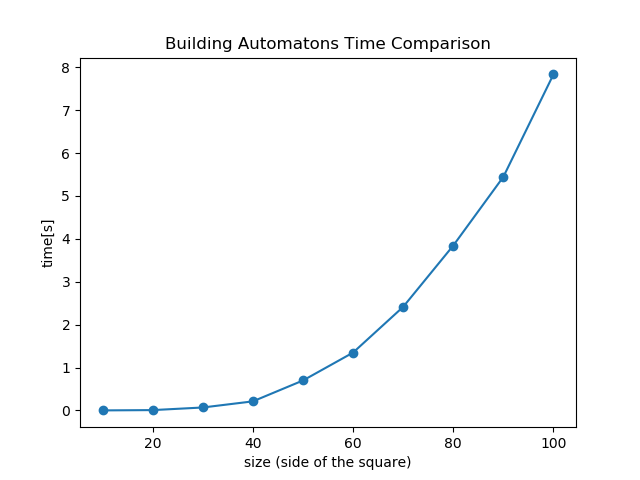

In [12]:
plt.close()
plt.plot(pattern_sizes, times, marker='o')
plt.title('Building Automatons Time Comparison')
plt.xlabel('size (side of the square)')
plt.ylabel('time[s]')
plt.show()

Czas budowy automatów rośnie szybko. Czas ten jednakże wystarczy poświęcić tylko jednokrotnie.

### Porównanie czasów wyszukiwania wzorca 
Wyszukiwany będzie wzorzec 20x20. Tekstami będą kwadraty, tak jak poprzednio, "wycięte" z pliku *haystack.png*.

In [13]:
pattern_start = 128
pattern_size = 20
pattern = [line[pattern_start:pattern_start + pattern_size] for line in text[pattern_start:pattern_start + pattern_size]]
automatons = build_automatons(pattern)
text_sizes = [100, 200, 300, 400, 500, 600, 700, 800]
times = []
for size in text_sizes:
    current_text = [line[:size] for line in text[:size]]
    start = time()
    string_matching_2d(current_text, pattern, automatons)
    end = time()
    times.append(end - start)

<IPython.core.display.Javascript object>


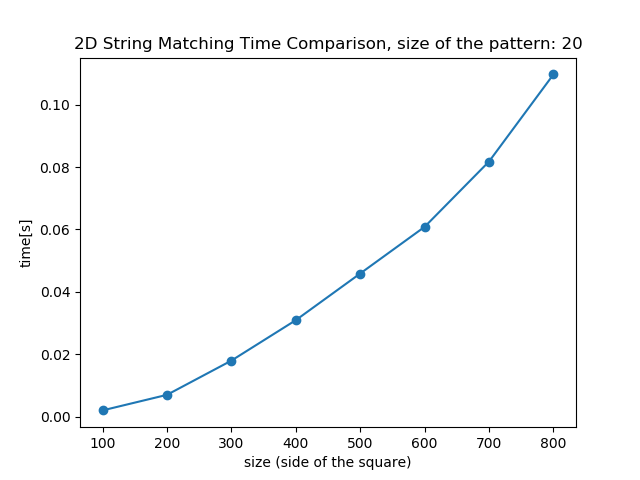

In [14]:
plt.close()
plt.plot(text_sizes, times, marker='o')
plt.title('2D String Matching Time Comparison, size of the pattern: 20')
plt.xlabel('size (side of the square)')
plt.ylabel('time[s]')
plt.show()

Teraz wyszukiwany będzie wzorzec 80x80.

In [15]:
pattern_start = 128
pattern_size = 80
pattern = [line[pattern_start:pattern_start + pattern_size] for line in text[pattern_start:pattern_start + pattern_size]]
automatons = build_automatons(pattern)
text_sizes = [100, 200, 300, 400, 500, 600, 700, 800]
times = []
for size in text_sizes:
    current_text = [line[:size] for line in text[:size]]
    start = time()
    string_matching_2d(current_text, pattern, automatons)
    end = time()
    times.append(end - start)

<IPython.core.display.Javascript object>


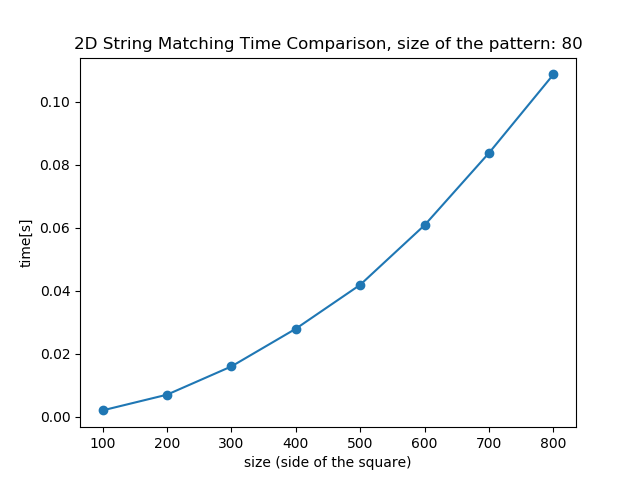

In [16]:
plt.close()
plt.plot(text_sizes, times, marker='o')
plt.title('2D String Matching Time Comparison, size of the pattern: 80')
plt.xlabel('size (side of the square)')
plt.ylabel('time[s]')
plt.show()

Wykresy wyglądają niemal identycznie. Czas wyszukiwania wzorca nie zależy więc od jego rozmiaru. Było to do przewidzenia, gdyż za sprawą wcześniej zbudowanego automatu, każda litera (w tym przypadku piksel) tekstu przeglądana jest jednokrotnie.

## Czasy wyszukiwania po podzieleniu pliku
Plik podzielono na 2, 4 i 8 fragmentów. Wyszukiwany będzie wzorzec 10x10.

In [17]:
pattern_start = 128
pattern_size = 10
pattern = [line[pattern_start:pattern_start + pattern_size] for line in text[pattern_start:pattern_start + pattern_size]]
automatons = build_automatons(pattern)
divisions = [1, 2, 4, 8]
times = []
for division in divisions:
    current_text = text[:(len(text) // division)]
    start = time()
    string_matching_2d(current_text, pattern)
    end = time()
    times.append(end - start)

<IPython.core.display.Javascript object>


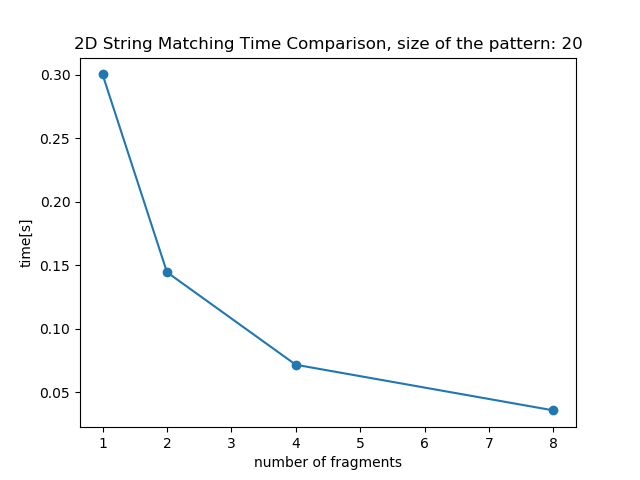

In [18]:
plt.close()
plt.plot(divisions, times, marker='o')
plt.title('2D String Matching Time Comparison, size of the pattern: 20')
plt.xlabel('number of fragments')
plt.ylabel('time[s]')
plt.show()

Tak jak można się było spodziewać, gdy liczba linii tekstu maleje dwukrotnie, czas też maleje mniej więcej dwukrotnie